# Model Evaluation

Compares fine-tuned models against the held-out test split using two prediction methods:
- **Method 1**: HuggingFace `pipeline()` (high-level, handles tokenization internally)
- **Method 2**: `AutoModelForSequenceClassification` + `AutoTokenizer` directly (manual batching, full control)


## Setup

In [ ]:
import os
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline
from datasets import load_dataset
from huggingface_hub import login
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

DATASET_ID = "ADS509/full_experiment_labels"

MODELS = {
    "RoBERTa": "ADS509/experiment_labels_roberta_base",
    "BERTweet": "ADS509/BERTweet-large-self-labeling",
    "BERT base": "ADS509/experiment_labels_bert_base",
}

print(f"PyTorch version: {torch.__version__}")
print(f"GPU available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.10.0+cu128
GPU available: True
GPU: NVIDIA A100-SXM4-40GB


In [118]:
# Helper function to get probabilities

def get_probs(logits):
    convert_tensor = torch.tensor(logits)
    probs = F.softmax(convert_tensor, dim=1)
    return probs

In [ ]:
login()


Running on: CUDA


## Load Test Data

In [43]:
dataset = load_dataset(DATASET_ID)

test_split = dataset["test"]
texts = test_split["text"]
true_labels = np.array(test_split["label"])

print(f"\nTest samples : {len(texts):,}")
unique, counts = np.unique(true_labels, return_counts=True)
print(f"Label distribution:")
for lbl, cnt in zip(unique, counts):
    print(f"  {lbl}: {cnt:,}")


Test samples : 10,558
Label distribution:
  0: 779
  1: 3,257
  2: 2,423
  3: 3,289
  4: 810


---
## Method 1: Pipeline

Uses `transformers.pipeline()` which handles tokenization, batching, and inference internally.
Simplest approach — good for quick evaluation and deployment.

In [47]:
def predict_pipeline(model_id: str, texts: list, device: int = 0, batch_size: int = 64) -> tuple:
    """
    Run text-classification predictions using a HuggingFace pipeline.

    Returns:
        pred_ints  : list of integer class predictions aligned with dataset label IDs
        id2label   : dict mapping integer IDs -> label name strings
    """
    pipe = pipeline(
        "text-classification",
        model=model_id,
        device=device,
        truncation=True,
        padding=True,
        batch_size=batch_size,
    )
    id2label = pipe.model.config.id2label
    label2id = pipe.model.config.label2id

    predictions = pipe(texts)
    pred_ints = [label2id[pred["label"]] for pred in predictions]
    return pred_ints, id2label

In [ ]:
pipeline_results = {}

for name, model_id in MODELS.items():
    print(f"\n{'='*60}")
    print(f"[Pipeline] {name}  —  {model_id}")
    print(f"{'='*60}")

    preds, id2label = predict_pipeline(model_id, texts, device=DEVICE, batch_size=BATCH_SIZE)
    label_names = [id2label[i] for i in sorted(id2label)]

    pipeline_results[name] = {"preds": preds, "id2label": id2label}

    print(classification_report(true_labels, preds, target_names=label_names))

---
## Method 2: Model + Tokenizer Directly

Loads `AutoModelForSequenceClassification` and `AutoTokenizer` separately, then runs
manual batched inference. Gives full control over tokenization, padding, and logits.

In [44]:
def predict_model_tokenizer(model_id: str, texts: list, device_str: str = "cuda", batch_size: int = 64) -> tuple:
    """
    Run text-classification predictions using AutoModel + AutoTokenizer directly.

    Returns:
        pred_ints  : list of integer class predictions aligned with dataset label IDs
        id2label   : dict mapping integer IDs -> label name strings
        all_logits : numpy array of raw logits (n_samples x n_classes), useful for ensembling
    """
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    model = AutoModelForSequenceClassification.from_pretrained(model_id)
    model.eval()
    model.to(device_str)

    id2label = model.config.id2label
    all_logits = []

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i : i + batch_size]
        inputs = tokenizer(
            batch_texts,
            truncation=True,
            padding=True,
            max_length=512,
            return_tensors="pt",
        ).to(device_str)

        with torch.no_grad():
            outputs = model(**inputs)

        all_logits.append(outputs.logits.cpu().float().numpy())

    all_logits = np.concatenate(all_logits, axis=0)      # (n_samples, n_classes)
    pred_ints = all_logits.argmax(axis=1).tolist()

    # Free GPU memory before loading the next model
    del model
    if device_str == "cuda":
        torch.cuda.empty_cache()

    return pred_ints, id2label, all_logits

In [45]:
pred_ints, id2label, all_logits = predict_model_tokenizer(
    model_id="ADS509/experiment_labels_roberta_base",
    texts=list(texts),
    batch_size=16)

config.json:   0%|          | 0.00/999 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

In [51]:
label_names = [id2label[i] for i in sorted(id2label)]

In [52]:
print(classification_report(true_labels, pred_ints, target_names=label_names, digits=4))

               precision    recall  f1-score   support

      Neutral     0.7271    0.6842    0.7050       779
      Opinion     0.7209    0.7270    0.7239      3257
Argumentative     0.7623    0.8048    0.7830      2423
   Expressive     0.8308    0.7945    0.8122      3289
Informational     0.6977    0.7210    0.7092       810

     accuracy                         0.7623     10558
    macro avg     0.7478    0.7463    0.7467     10558
 weighted avg     0.7633    0.7623    0.7625     10558



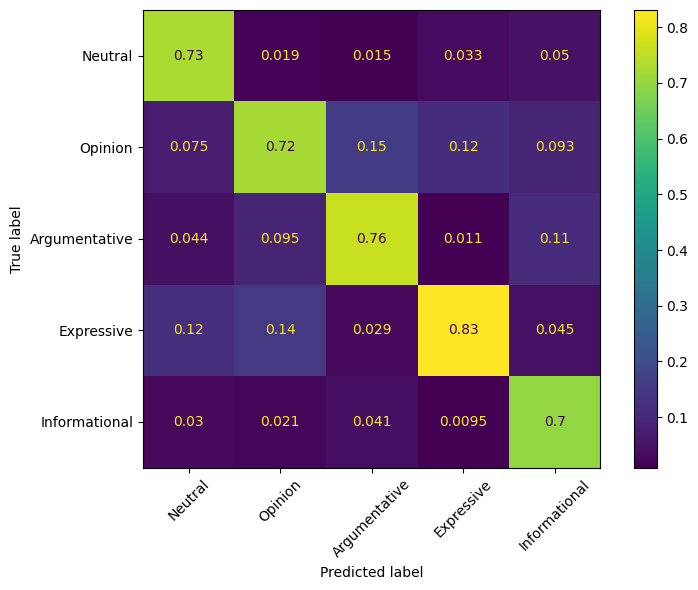

In [116]:
fig, ax = plt.subplots(figsize=(8, 6))

ConfusionMatrixDisplay.from_predictions(
    true_labels, pred_ints, 
    display_labels=label_names, 
    xticks_rotation=45,
    normalize='pred',
    ax=ax)

plt.tight_layout()
plt.show()

In [ ]:
probs = get_probs(all_logits)
array = np.asarray(probs)

results = np.max(array, axis=1)
bool_arr = results < 0.5

In [155]:
df = test_split.to_pandas()

df['low_conf'] = bool_arr
df['pred'] = pred_ints

In [ ]:
df['label'] = df['label'].apply(lambda x: id2label[x])
df['pred'] = df['pred'].apply(lambda x: id2label[x])

In [168]:
idx = 7

print("True label: ", df[df['low_conf'] == True]['label'].iloc[idx])
print("Predicted label: ", df[df['low_conf'] == True]['pred'].iloc[idx], "\n")
print("Text:\n\n", df[df['low_conf'] == True]['text'].iloc[idx])

True label:  Opinion
Predicted label:  Informational 

Text:

 the best part is that after this happened, utility bills went up around the country to help subsidize the consequences of their grid being ass.
